# A3 BIG DATA

## Premissa

Fomos contratados por uma empresa varejista de roupas para alavancar suas vendas. Ela nos ofereceu o seu registro de vendas, disponível em formato CSV e nos solicitou em retorno a criação de uma estratégia de marketing e um mapeamento mais específico de seu público alvo (persona) atualmente

## Objetivos da estratégia de marketing:

- Satisfação do cliente
- Quantidade de produtos vendidos em cada marca
- Lucro líquido (com desconto aplicado)
- Encontar carro chefe de vendas
- Encontrar temporada preferida do publico alvo
- Encontrar gênero que é mais atendido
- Encontar material mais vendido

marcas_populares = [
    "Adidas",
    "Lupo",
    "Mizuno",
    "Mormaii",
    "Fila",
    "Zorba",
    "Menina Linda",
    "MultiMarcas",
    "Stillger Jeans",
    "Mash",
    "Keeper",
    "Almix",
    "Imperio Kids",
    "AMANDIKA KIDS",
    "Levi's",
    "Slim Fitness",
    "New Era",
    "Paraíso da Lingerie",
    "Importado",
    "Genérica",
    "Olympikus",
    "Puma",
    "Under Armour"
]:

## Instalar depdendências

In [1]:
# Instalar dependências
get_ipython().system_raw('pip install pandas')
get_ipython().system_raw('pip install findspark')
get_ipython().system_raw('pip install matplotlib')
get_ipython().system_raw('pip install squarify')
get_ipython().system_raw('pip install loguru')

/home/thiago/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2607: UserWarning: You executed the system command !pip which may not work as expected. Try the IPython magic %pip instead.
  warnings.warn(


# Configurações iniciais - tratar xlsx para criar um .csv

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "./spark-3.1.2-bin-hadoop2.7"
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pandas as pd
from loguru import logger

spark = SparkSession.builder.appName(
    'A3 Análise de dados e Big Data').getOrCreate()

roupas = spark.read.csv(path='./data/clothes_db.csv', sep=',')
roupas = roupas.fillna("Sem avaliação")
logger.info("Configuração pronta!")

23/10/10 01:38:44 WARN Utils: Your hostname, W10-tks resolves to a loopback address: 127.0.1.1; using 172.25.91.212 instead (on interface eth0)
23/10/10 01:38:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/10/10 01:38:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-10-10 01:39:05.195 | INFO     | __main__:<module>:15 - Configuração pronta!


## Tratamento de dados - renomear colunas

In [3]:
roupasColNames = [
    'titulo', 
    'preco_original', 
    'desconto_percentual', 
    'preco_com_desconto', 
    'quantidade_vendida', 
    'marca', 
    'material',
    'genero',
    'temporada',
    'nota_satisfacao',
    'quantidade_avals'
]
for index, colname in enumerate(roupasColNames):
    roupas = roupas.withColumnRenamed(f"_c{index}", colname)
roupas.printSchema()
roupas.select("*").where(roupas.quantidade_vendida >= 1000).show(999999)

root
 |-- titulo: string (nullable = false)
 |-- preco_original: string (nullable = false)
 |-- desconto_percentual: string (nullable = false)
 |-- preco_com_desconto: string (nullable = false)
 |-- quantidade_vendida: string (nullable = false)
 |-- marca: string (nullable = false)
 |-- material: string (nullable = false)
 |-- genero: string (nullable = false)
 |-- temporada: string (nullable = false)
 |-- nota_satisfacao: string (nullable = false)
 |-- quantidade_avals: string (nullable = false)



+--------------------+--------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+---------------+----------------+
|              titulo|preco_original|desconto_percentual|preco_com_desconto|quantidade_vendida|               marca|            material|             genero|           temporada|nota_satisfacao|quantidade_avals|
+--------------------+--------------+-------------------+------------------+------------------+--------------------+--------------------+-------------------+--------------------+---------------+----------------+
|Pijama Cirurgico ...|      R$ 69.90|                 0%|          R$ 69.90|              1000|TORONTO UNIFORMES...|           Poliéster|         Sem gênero|                 N/A|              4|             273|
|Kit 10 Cuecas Box...|     R$ 274.81|                18%|         R$ 232.89|             10000|                Lupo|             Algodão|          Mascu

In [42]:
import pyspark.sql
from pyspark.sql.functions import col

def pega_vendas_da_marca(company_name:str) -> pyspark.sql.dataframe.DataFrame :
    return roupas.select("*").where(col("marca").contains(company_name))

def salvar_csv_marcas_populares(path:str) -> None:
    (dados_marcas_populares.toPandas()).to_csv(path)
    
path = "./data/db_tratado.csv"

marcas_populares = [
    "adidas",
    "Lupo",
    "Mizuno",
    "Mormaii",
    "Fila",
    "Zorba",
    "Menina Linda",
    "MultiMarcas",
    "Stillger Jeans",
    "Mash",
    "Keeper",
    "Almix",
    "Imperio Kids",
    "AMANDIKA KIDS",
    "Levi's",
    "Slim Fitness",
    "New Era",
    "Paraíso da Lingerie",
    "Importado",
    "Genérica",
    "Olympikus",
    "Puma",
    "Under Armour"
]


vendas_marcas_populares = {
    marca: pega_vendas_da_marca(marca) for marca in marcas_populares
}
dados_marcas_populares = vendas_marcas_populares["adidas"]

for marca in marcas_populares[1:]:
    dados_marcas_populares  = dados_marcas_populares.union(vendas_marcas_populares[marca])
    
salvar_csv_marcas_populares(path)
logger.info(f"CSV salvo em {path}")

2023-10-10 01:58:15.783 | INFO     | __main__:<module>:48 - CSV salvo em ./data/db_tratado.csv


# Gráfico de comparação de quantidade vendida

2023-10-10 03:54:47.867 | DEBUG    | __main__:<module>:27 - Valores_y - grafico qtd/marca: [1160.0, 292032.0, 4.0, 10.0, 5.0, 288335.0, 8643.0, 53925.0, 20105.0, 75583.0, 40909.0, 81000.0, 34685.0, 60000.0, 2661.0, 2000.0, 1.0, 7205.0, 3507.0, 43590.0, 130.0, 1008.0, 8.0]


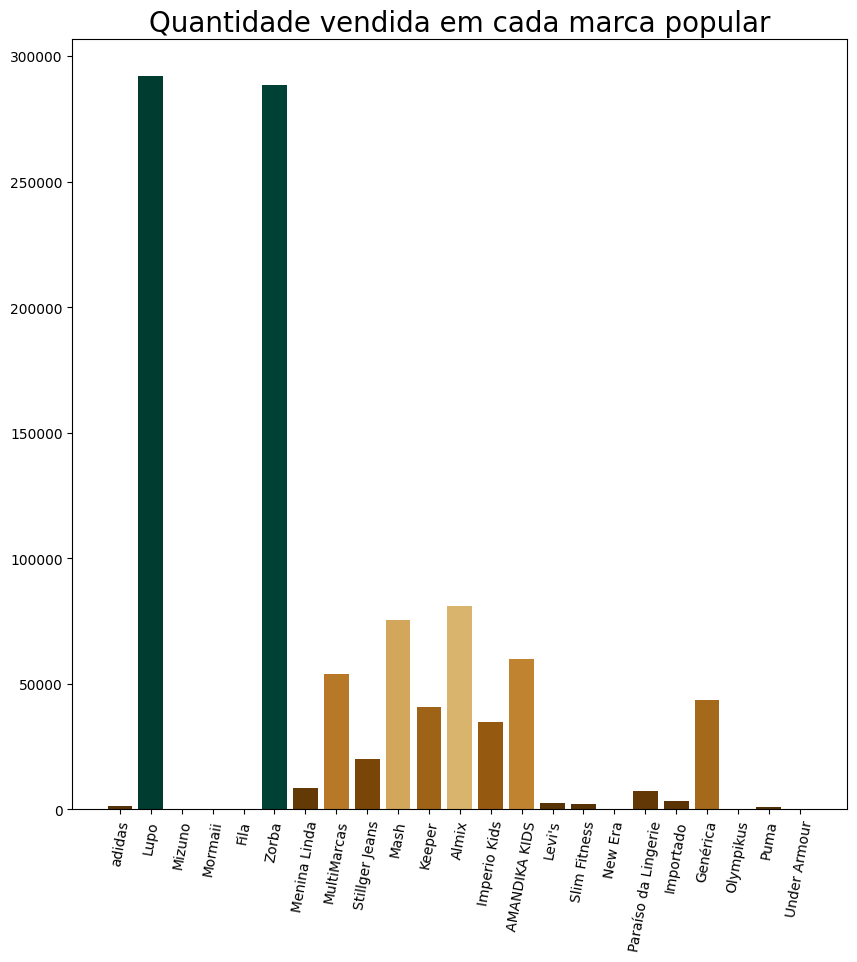

In [146]:
import matplotlib
from matplotlib import pyplot as plt

def soma_qtd_vendida(marca:str) -> float:
    return sum([
        float(row[0]) for row in
        vendas_marcas_populares[marca].select("quantidade_vendida").collect()
    ])

def monta_grafico_barra(x,y, color, titulo:str) -> None:
    plt.figure(figsize=(10,10))
    plt.title(titulo, fontsize=20)
    plt.bar(x,y, color = color)
    plt.xticks(rotation=80)
    plt.show()
    

def monta_lista_cores(lista, cmap):
    mini = min(lista)
    maxi = max(lista)
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    return [cmap(norm(i)) for i in lista]

somas_vendas = [
    soma_qtd_vendida(marca) for marca in vendas_marcas_populares
]
logger.debug("Valores_y - grafico qtd/marca: " + str(somas_vendas))

cmap = matplotlib.cm.BrBG
colors = monta_lista_cores(somas_vendas, cmap)

monta_grafico_barra(marcas_populares, somas_vendas, colors, "Quantidade vendida em cada marca popular")


# Comparação de lucros feitos por cada marca

Pra fazer esse gráfico, o tamanho dos retânglos precisam ser porcentagens com relação ao preço máximodo dataset
pra ter uma lista de lucros, eu preciso multiplicar o valor com desconto com a quantidade, dai somar esses valores de cada marca

2023-10-10 03:54:54.749 | DEBUG    | __main__:<module>:17 - lista_vendas: [207037.9, 33844741.46, 489.96, 510.95, 767.68, 54380476.75, 1010643.81, 9592976.24, 1190971.4, 15574980.4, 2017177.24, 12476300.0, 4892919.95, 8394000.0, 854481.87, 86000.0, 339.99, 379427.95, 336544.73, 1712429.65, 15591.2, 161839.92, 1887.84]
2023-10-10 03:54:54.784 | DEBUG    | __main__:<module>:23 - lista_de_porcentagens: [0.14, 23.0, 0.0, 0.0, 0.0, 36.96, 0.69, 6.52, 0.81, 10.59, 1.37, 8.48, 3.33, 5.71, 0.58, 0.06, 0.0, 0.26, 0.23, 1.16, 0.01, 0.11, 0.0]


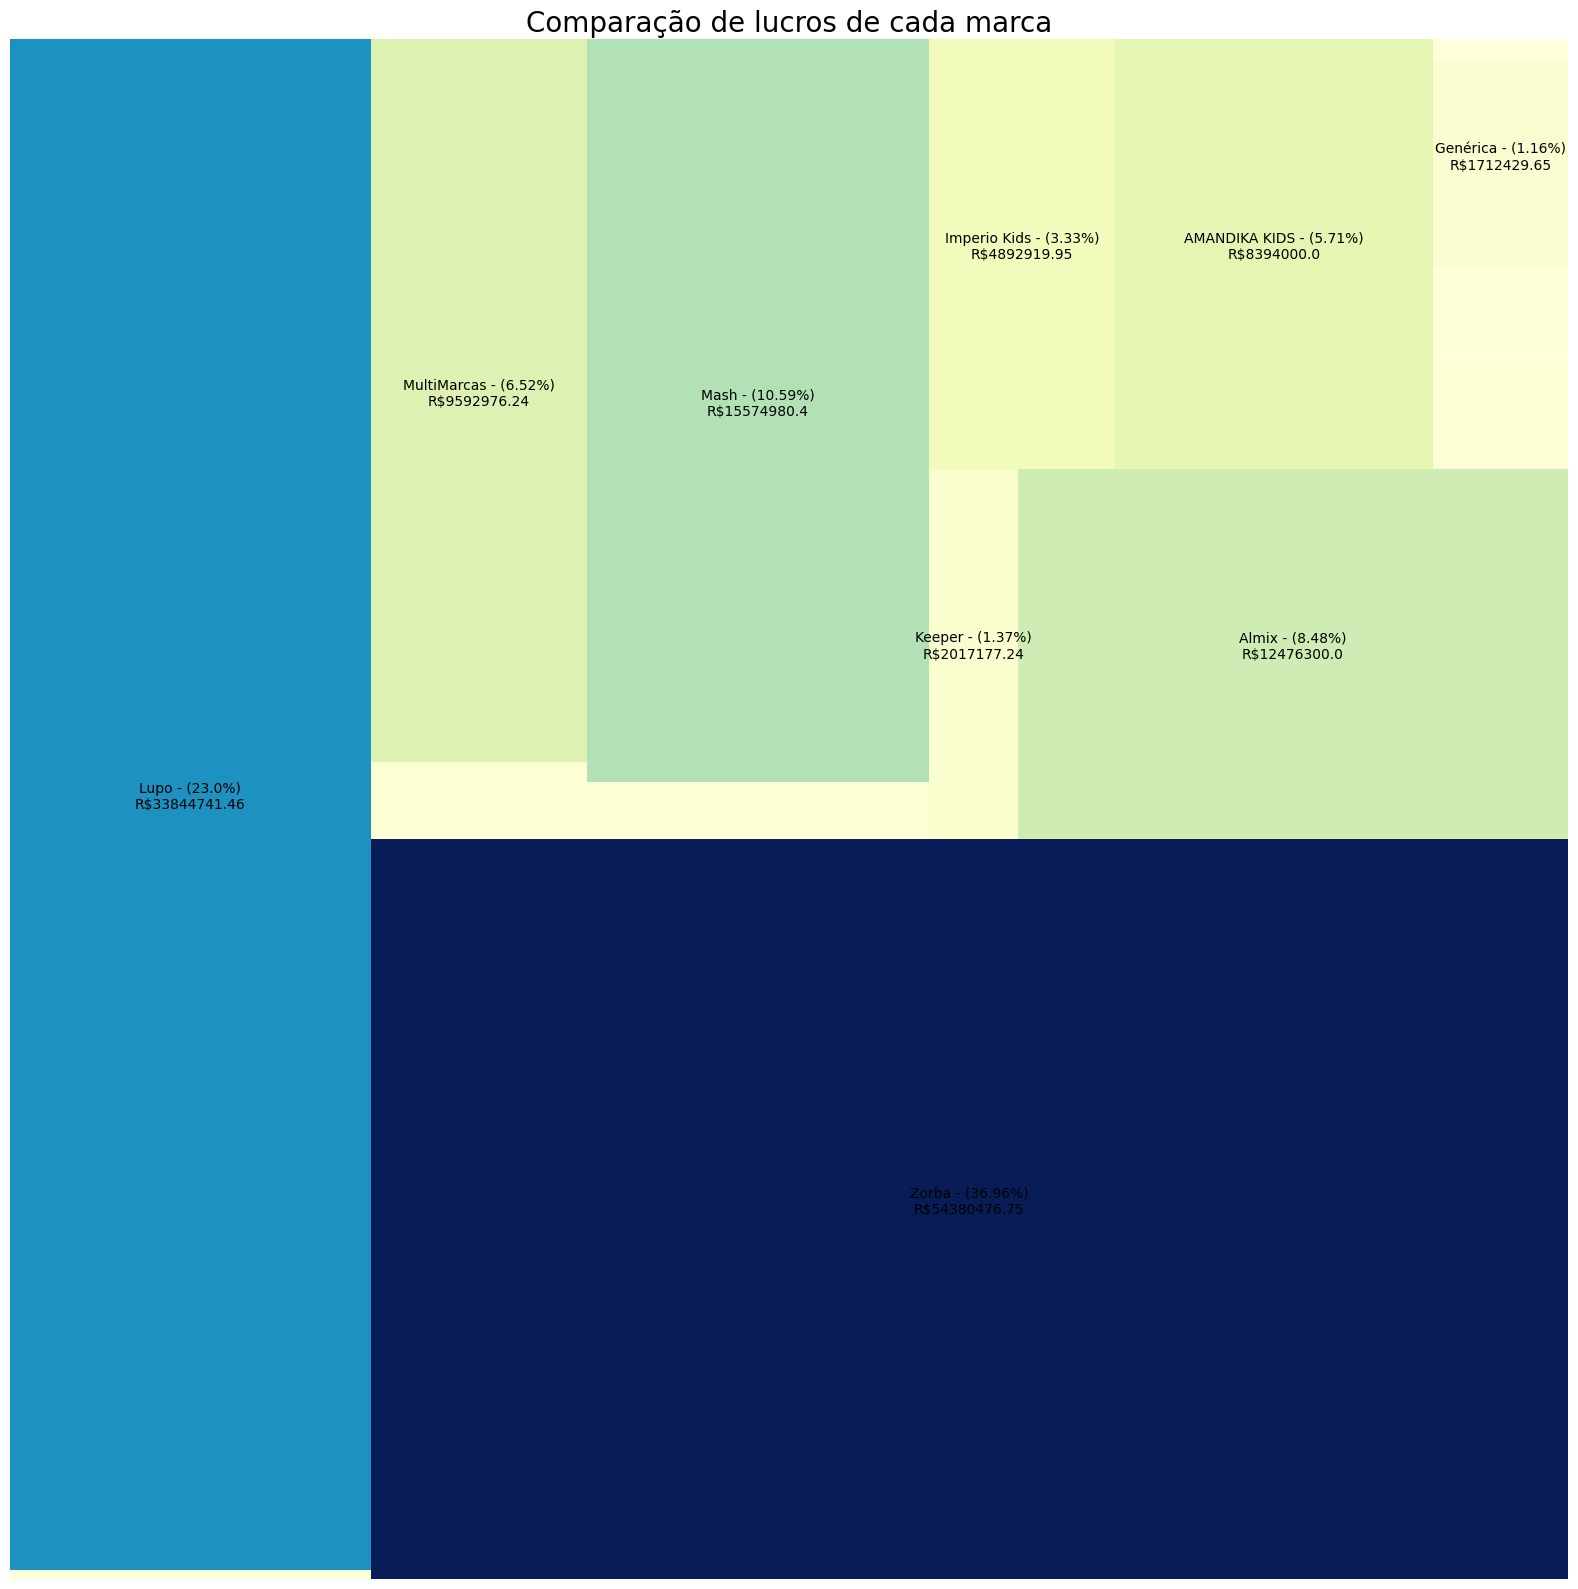

In [147]:
import matplotlib
import squarify

def monta_grafico_squarify(sizes, label, color, titulo:str) -> None:
    plt.figure(figsize=(16,16))
    grafico = squarify.plot(sizes=sizes,label=label,color=color)
    plt.axis('off');
    plt.title(titulo, fontsize=20)
    plt.tight_layout()

lista_vendas = [
    round(sum([
        (float(row[0].replace("R$ ", "")) * float(row[1]) ) for row in
        vendas_marcas_populares[marca].select("preco_com_desconto", "quantidade_vendida" ).collect()
    ]),2) for marca in vendas_marcas_populares
]
logger.debug(f"lista_vendas: {lista_vendas}")

lista_de_porcentagens = [
    round((item*100)/sum(lista_vendas),2) for item in
    lista_vendas
]
logger.debug(f"lista_de_porcentagens: {lista_de_porcentagens}")

legendas = [
    (
        marcas_populares[index]  + " - " + 
        "("+ str(lista_de_porcentagens[index]) + "%)\n" +
        "R$" + str(lista_vendas[index]) + "\n"
        if float(lista_de_porcentagens[index]) > 1 else ""
    ) for (index,item) in
    enumerate(marcas_populares)
]


cmap = matplotlib.cm.YlGnBu
colors = monta_lista_cores(lista_vendas, cmap)

monta_grafico_squarify(sizes=lista_vendas, label=legendas, color=colors, titulo='Comparação de lucros de cada marca')

# COMPARAÇÃO DE PREÇOS DOS ARTIGOS MAIS BARATOS DE CADA LOJA

Pra fazer esse gráfico, o tamanho dos retânglos precisam ser porcentagens com relação ao preço mínimo da coluna de desconto
### GRÁFICO MONTADO DE FORMA QUE OS CAMPOS MAIS CLAROS REPRESENTAM OS PREÇOS MAIS ACESSÍVEIS, ENQUANTO OS ESCUROS REPRESENTAM OS MAIS CAROS

2023-10-10 03:55:54.319 | DEBUG    | __main__:<module>:10 - Lista preços - grafico preços acessíveis por marca: [119.99, 19.92, 99.99, 42.29, 119.99, 43.38, 29.9, 30.9, 41.99, 19.9, 42.11, 64.9, 112.82, 139.9, 299.0, 36.6, 339.99, 44.99, 32.18, 19.13, 78.99, 99.99, 119.9]
2023-10-10 03:55:54.320 | DEBUG    | __main__:<module>:15 - Lista preços - grafico preços acessíveis por marca: [119.99, 19.92, 99.99, 42.29, 119.99, 43.38, 29.9, 30.9, 41.99, 19.9, 42.11, 64.9, 112.82, 139.9, 299.0, 36.6, 339.99, 44.99, 32.18, 19.13, 78.99, 99.99, 119.9]


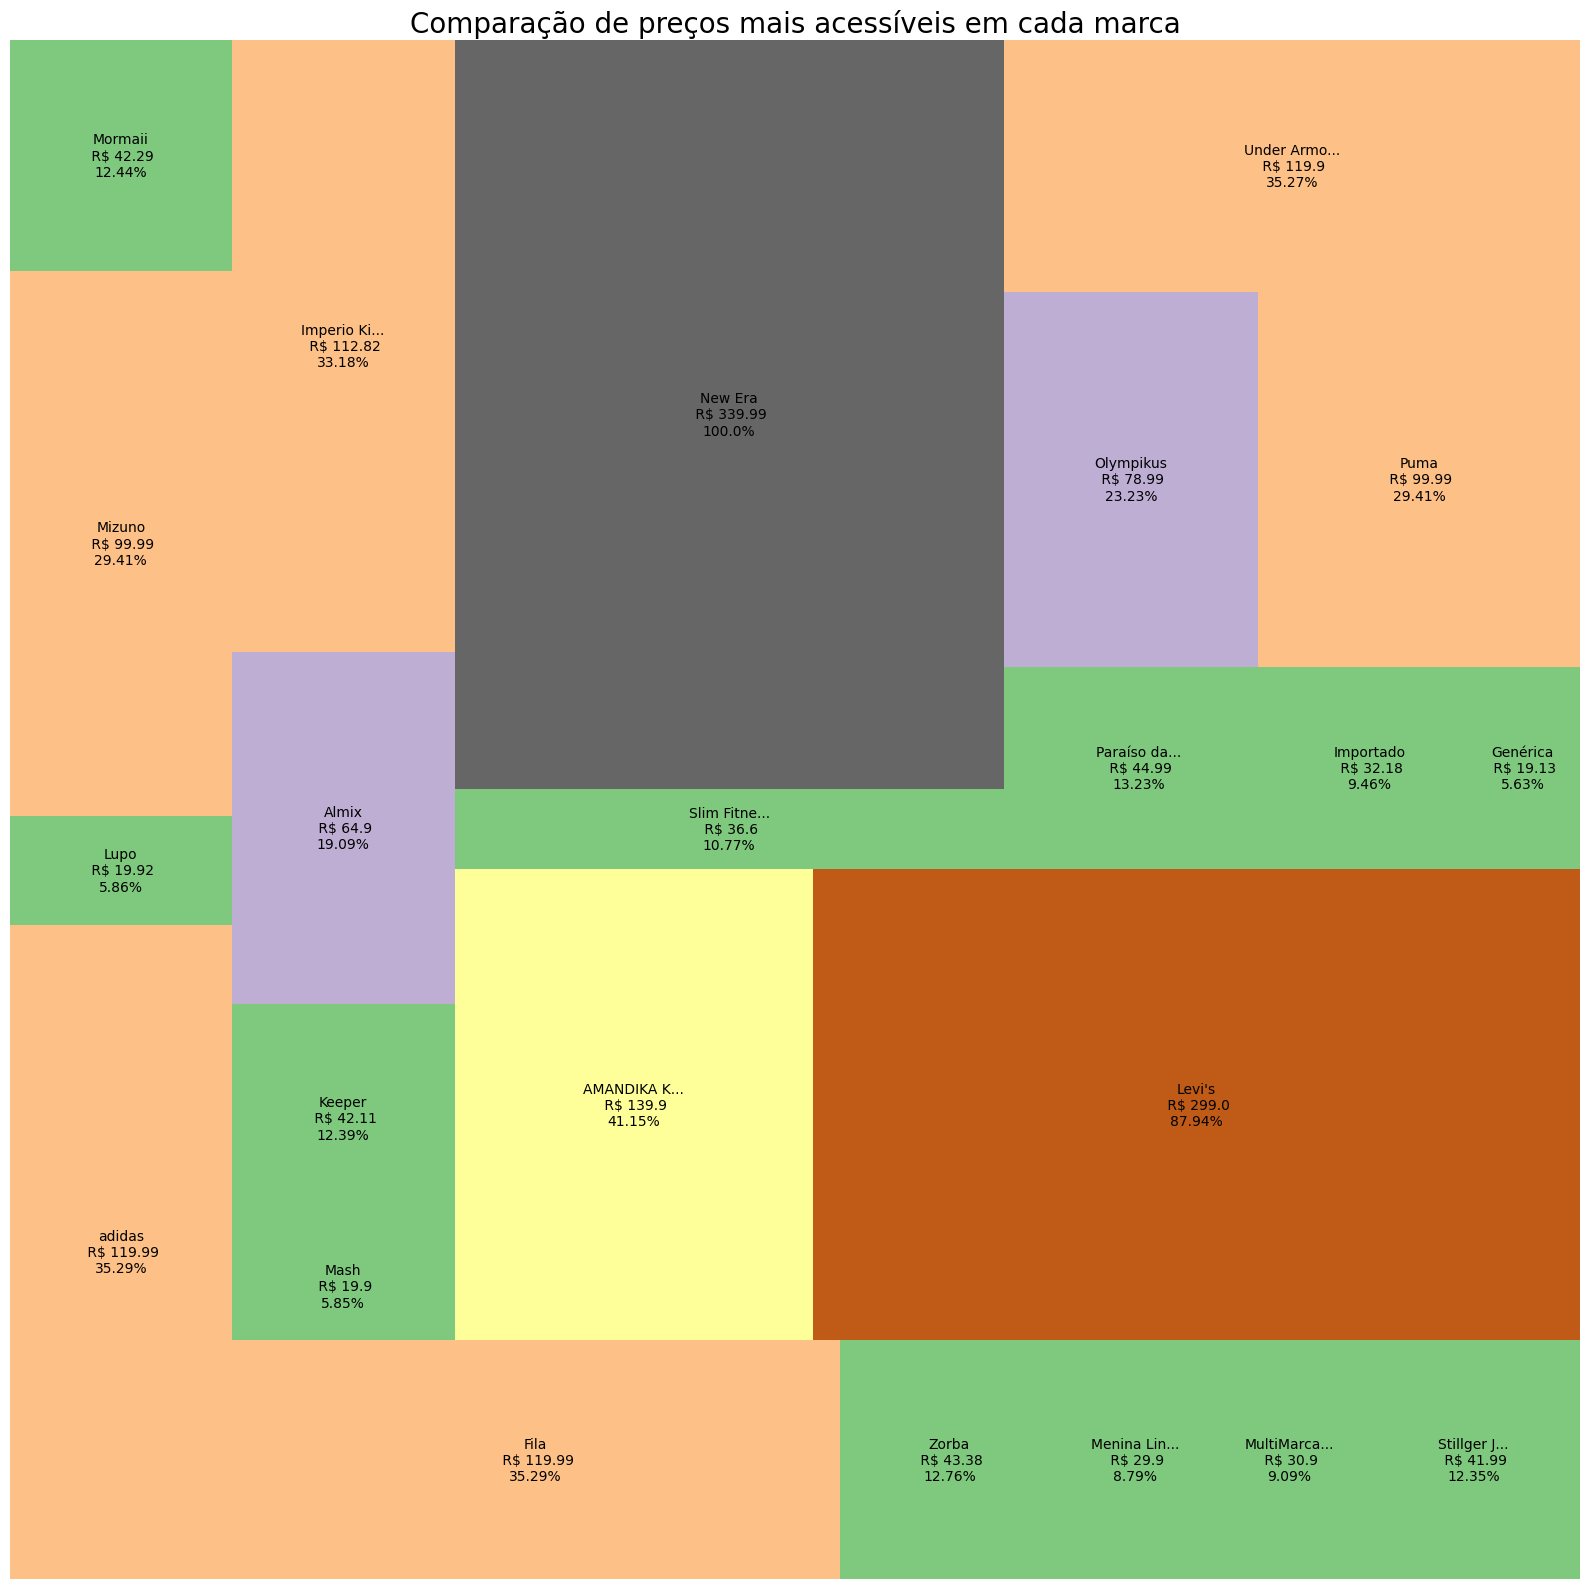

In [148]:
import matplotlib
import squarify

lista_precos = [
    min([
        float(row[0].replace("R$ ", "")) for row in
        vendas_marcas_populares[item].select("preco_com_desconto").collect()
    ]) for item in vendas_marcas_populares
]
logger.debug("Lista preços - grafico preços acessíveis por marca: " + str(lista_precos))
lista_de_porcentagens = [
    round((item*100)/max(lista_precos),2) for item in
    lista_precos
]
logger.debug("Lista preços - grafico preços acessíveis por marca: " + str(lista_precos))
legendas = [
    (marcas_populares[index][:10] + "...\n" if len(marcas_populares[index]) > 10 else marcas_populares[index] + "\n") +
    " R$ " + str(lista_precos[index])  + "\n" +
    str(lista_de_porcentagens[index]) + "%" for (index,item) in
    enumerate(marcas_populares)
]

cmap = matplotlib.cm.Accent
colors = monta_lista_cores(lista_precos,cmap)

monta_grafico_squarify(sizes=lista_precos, label=legendas, color=colors, titulo='Comparação de preços mais acessíveis em cada marca')

# COMPARAÇÃO DE AVALIAÇÕES ENTRE MARCAS

Existem 5 marcas dentro da amostra escolhida que não possuem nenhuma avaliação. Por isso, foi necessário considerar o valor delas como zero no gráfico, por fins de comparação, porém na verdade seria interessante adquirir mais dados dessas marcas para melhores resultados

2023-10-10 03:58:46.005 | DEBUG    | __main__:<module>:19 - media das avaliações: [2.0083333333333337, 3.3419354838709667, 0.0, 0.0, 0.0, 3.7299999999999995, 3.1181818181818186, 2.8500000000000005, 3.405882352941175, 3.25, 2.163157894736842, 3.725000000000001, 2.9947368421052634, 3.8000000000000003, 3.28, 3.8333333333333335, 0.0, 3.685714285714286, 2.1999999999999997, 2.7285714285714286, 2.94, 0.775, 0.0]


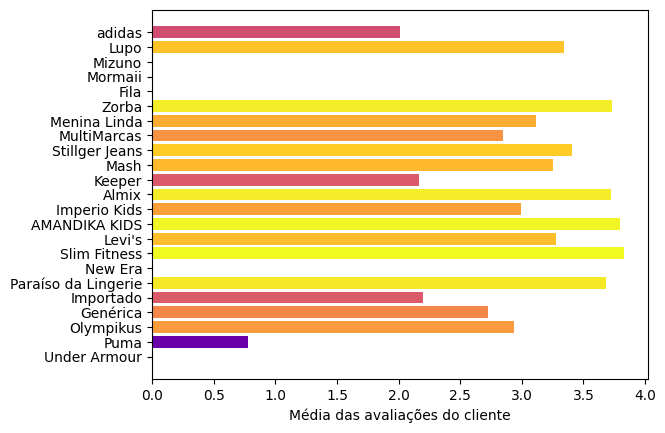

In [149]:
import matplotlib
import numpy as np

def monta_barras_horizontais(eixo_y, eixo_x, y_pos, colors, label_x) -> None:
    fig, ax = plt.subplots()
    y_pos = np.arange(len(eixo_y))
    ax.barh(y_pos, eixo_x, color=colors)
    ax.set_yticks(y_pos, eixo_y)
    ax.invert_yaxis()  # labels de cima pra baixo
    ax.set_xlabel(label_x)

media_notas = [
    sum([
        (float(row[0]) if row[0] != "Sem avaliação" else 0) for row in
        vendas_marcas_populares[item].select("nota_satisfacao").collect()
    ])/len(vendas_marcas_populares[item].select("nota_satisfacao").collect())
    for item in vendas_marcas_populares
]
logger.debug("media das avaliações: " + str(media_notas))
# Definindo a paleta de cores para o treemap
cmap = matplotlib.cm.plasma
colors = monta_lista_cores(media_notas, cmap)

monta_barras_horizontais(marcas_populares, media_notas, y_pos, colors, 'Média das avaliações do cliente')


2023-10-10 04:02:49.351 | DEBUG    | __main__:<module>:21 - qtd em cada marca p/ categorias de moda: [790018.0, 34945.0, 44051.0, 0, 10120.0, 60570.0, 10.0]


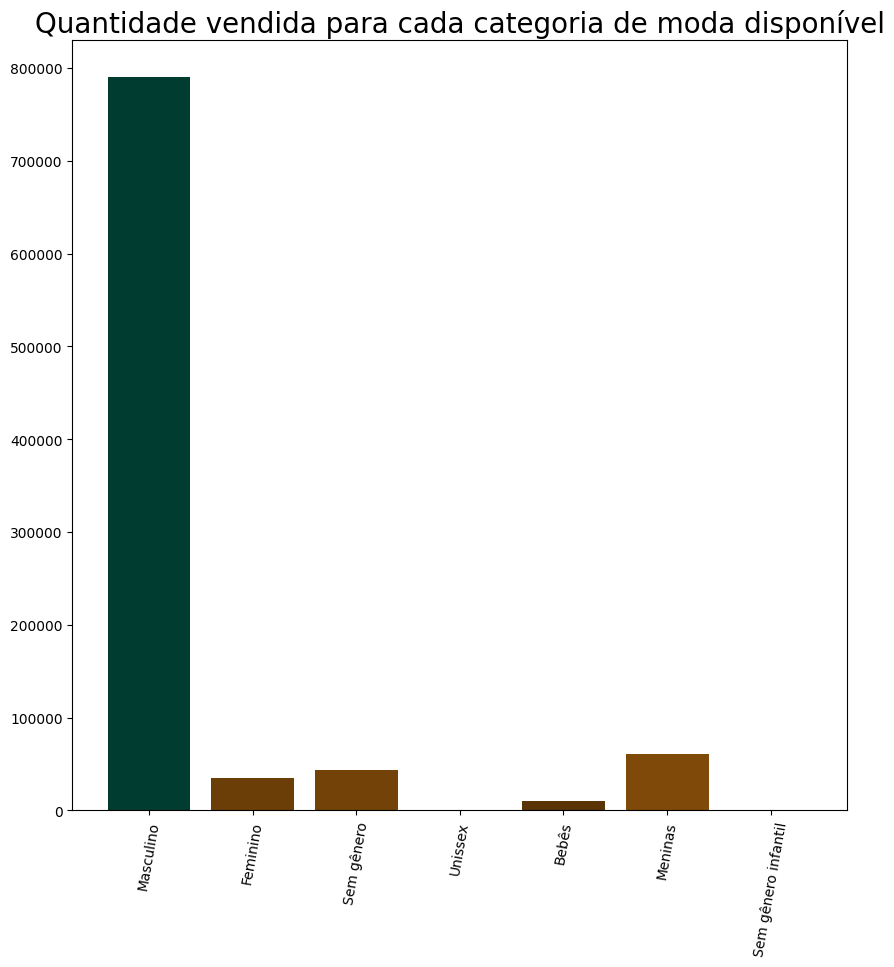

In [150]:
from typing import List

categorias_moda = [
    "Masculino",
    "Feminino",
    "Sem gênero",
    "Unissex",
    "Bebês",
    "Meninas",
    "Sem gênero infantil"
]

def soma_qtd_vendida_em_cada_marca_filtrando(categoria_moda:str)-> List[float]:
    return [sum([float(row[0]) for row in 
    vendas_marcas_populares[marca].select("quantidade_vendida").where(vendas_marcas_populares[marca].genero == categoria_moda).collect()]) for marca in
    marcas_populares]

quantidade_vendida_em_cada_marca =[
    round(sum(soma_qtd_vendida_em_cada_marca_filtrando(categoria)),2) for categoria in categorias_moda
]
logger.debug("qtd em cada marca p/ categorias de moda: " + str(quantidade_vendida_em_cada_marca) )
cmap = matplotlib.cm.BrBG
colors = monta_lista_cores(quantidade_vendida_em_cada_marca, cmap)

monta_grafico_barra(categorias_moda, quantidade_vendida_em_cada_marca, colors, "Quantidade vendida para cada categoria de moda disponível")

2023-10-10 04:06:05.607 | DEBUG    | __main__:<module>:21 - lista categorias sem especif. [479714.0, 27458.0, 100.0]
2023-10-10 04:06:08.768 | DEBUG    | __main__:<module>:25 - lista qtd antes de add [404161.0, 76564.0]
2023-10-10 04:06:08.770 | DEBUG    | __main__:<module>:32 - lista qtd dps de add [404161.0, 76564.0, 507272.0]


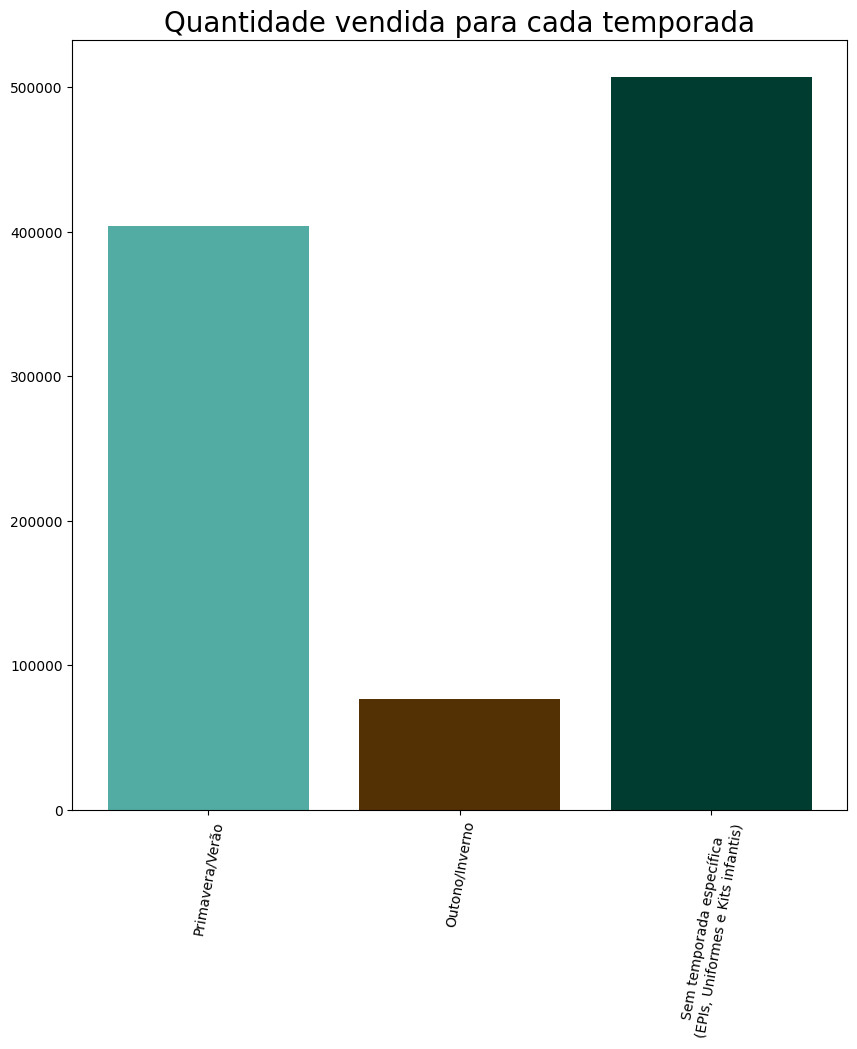

In [153]:
import matplotlib

def soma_qtd_vendida_em_cada_marca_filtrando(temporada:str)-> List[float]:
    return [sum([float(row[0]) for row in 
    vendas_marcas_populares[marca].select("quantidade_vendida").where(vendas_marcas_populares[marca].temporada == temporada).collect()]) for marca in
    marcas_populares]


temporadas = [
    "Primavera/Verão",
    "Outono/Inverno",
]
categorias_nao_especificas = [
    "N/A",
    "Primavera-verão Outono-inverno",
    "Primavera/Verão Outono/Inverno"
]
lista_cats_na = [
    round(sum(soma_qtd_vendida_em_cada_marca_filtrando(temporada)),2) for temporada in categorias_nao_especificas
]
logger.debug("lista categorias sem especif. " + str(lista_cats_na))
lista_qtd_cada_marca = [
    round(sum(soma_qtd_vendida_em_cada_marca_filtrando(temporada)),2) for temporada in temporadas
]
logger.debug("lista qtd antes de add " + str(lista_qtd_cada_marca))
# Com essa adição, agora ficam 3 categorias:
# "Primavera/Verão",
# "Outono/Inverno",
# "Sem temporada específica",
lista_qtd_cada_marca.append(sum(lista_cats_na))
temporadas.append("Sem temporada específica\n(EPIs, Uniformes e Kits infantis)")
logger.debug("lista qtd dps de add " + str(lista_qtd_cada_marca))

cmap = matplotlib.cm.BrBG
colors = monta_lista_cores(lista_qtd_cada_marca, cmap)

monta_grafico_barra(temporadas, lista_qtd_cada_marca, colors, "Quantidade vendida para cada temporada")